**Intersection over Union (IOU)** -- how accurate the bounding box prediction is. Shows the difference between true and predicted area.

**F1 score** -- calcualtes the average between precision and recall.

Cosine Similarity, Euclidean Distance and L2 form -- deepface

In [1]:
from deepface import DeepFace

In [107]:
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import reduce
import time

In [3]:
target = pd.read_csv('/home/daria/target_labels.csv')

path = '/home/daria/photos/'
target['path'] = target.img_name.apply(lambda row: path + row)

In [5]:
hyp = lambda x1, x2, y1, y2: np.sqrt(
    (x2-x1)**2 + (y2-y1)**2
)

# function to plot the picture with the face bounding box from the target
def pic(**kwargs):
    im = imageio.imread(kwargs['path'])
    fig, ax = plt.subplots()
    ax.imshow(im)
    d = hyp(kwargs['x1'], kwargs['x2'], kwargs['y1'], kwargs['y2'])
    rect = patches.Rectangle(
        (kwargs['x1'], kwargs['y1']),
         kwargs['x2'],
         kwargs['y2'],
         linewidth=1, edgecolor='r', facecolor='none')
 
    ax.add_patch(rect)
    fig.show()
    return ax

def get_iou(bb1, bb2):
    
    bb1['x1'] = bb1['x']
    bb1['y1'] = bb1['y']
    bb1['y2'] = bb1['h'] + bb1['y']
    bb1['x2'] = bb1['w'] + bb1['x']
    
    bb2['x1'] = bb2['x']
    bb2['y1'] = bb2['y']
    bb2['y2'] = bb2['h'] + bb2['y']
    bb2['x2'] = bb2['w'] + bb2['x']

    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

# function to get the rectangle coordinates formatted in a special way for DeepFace output
def get_rect(**kwargs):
    h = hyp(kwargs['x1'], kwargs['x2'], kwargs['y1'], kwargs['y2'])
    l = h / np.sqrt(2)
    return {
        'x': kwargs['x1'], 'y': kwargs['y1'],
        'w': l, 'h': l
    }

<AxesSubplot:>

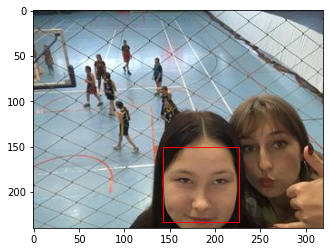

In [6]:
bb_coords_dict = get_rect(**target.iloc[0])
pic(path=target['path'][0], 
    x1=bb_coords_dict['x'], 
    y1=bb_coords_dict['y'], 
    x2=bb_coords_dict['w'], 
    y2=bb_coords_dict['h'])

In [7]:
bb_coords_dict

{'x': 143.0, 'y': 150.0, 'w': 83.57332110189232, 'h': 83.57332110189232}

### DeepFace Models

In [237]:
models = ['opencv', 'ssd', 'mtcnn', 'retinaface', 'dlib']

results = {}
for model in models:
    ious = []
    for i, img in target.iterrows():
        try:
            face = DeepFace.analyze(img.path, actions = ['emotion'],
                                    enforce_detection=False, 
                                    detector_backend=model,
                                    prog_bar=False
            )
        except ValueError:
            continue
        ious.append(
            get_iou(
                get_rect(**img),
                face['region']
            )
        )
    results[model] = ious


1/1 [==============================] - 0s 12ms/step


In [50]:
# mean IOU score for every model

for key,value in results.items(): 
    print(key, reduce(lambda x, y: x + y, results[key]) / len(results[key]))

opencv 0.2504465899505834
ssd 0.3126681011803038
mtcnn 0.4243546398672994
retinaface 0.5212247451641149
dlib 0.30331248470151967


Text(0, 0.5, 'IOUs')

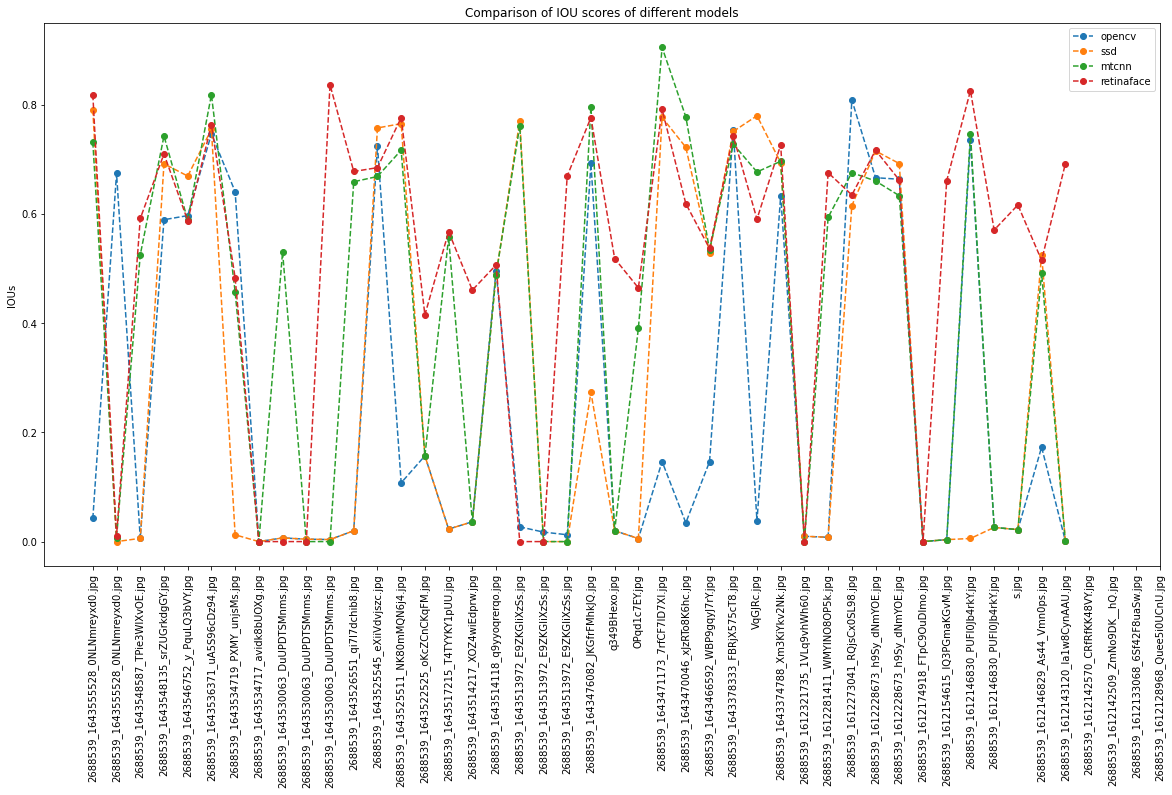

In [31]:
plt.figure(figsize=(20, 10))
for k, v in results.items():
    plt.plot(v, '--o', label=k)

plt.xticks(range(len(target.img_name)), target.img_name, rotation=90)
plt.legend()
plt.title('Comparison of IOU scores of different models')
plt.ylabel('IOUs')
    

### Measuring the time it takes to process one photo

In [115]:
start = time.time()

# DeepFace.analyze(target.path[0], actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='opencv')
# end = time.time()
# print(end - start)


# DeepFace.analyze(target.path[0], actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='ssd')
# end = time.time()
# print(end - start)

# DeepFace.analyze(target.path[0], actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='mtcnn')
# end = time.time()
# print(end - start)

# DeepFace.analyze(target.path[0], actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='retinaface')
# end = time.time()
# print(end - start)

DeepFace.analyze(target.path[0], actions = ['emotion'],
                                    enforce_detection=False, 
                                    detector_backend='dlib')
end = time.time()
print(end - start)

1/1 [==============================] - 0s 12ms/step
0.07023429870605469


### Measuring the time it takes to process 10 photos

In [119]:
start = time.time()

# DeepFace.analyze(list(target.path[:10]), actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='opencv')
# end = time.time()
# print(end - start)


# DeepFace.analyze(list(target.path[:10]), actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='ssd')
# end = time.time()
# print(end - start)

# DeepFace.analyze(list(target.path[:10]), actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='mtcnn')
# end = time.time()
# print(end - start)

# DeepFace.analyze(list(target.path[:10]), actions = ['emotion'],
#                                     enforce_detection=False, 
#                                     detector_backend='retinaface')
# end = time.time()
# print(end - start)

DeepFace.analyze(list(target.path[:10]), actions = ['emotion'],
                                    enforce_detection=False, 
                                    detector_backend='dlib')
end = time.time()
print(end - start)

Analyzing:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


Analyzing:  20%|██        | 2/10 [00:00<00:00, 15.53it/s]

1/1 [==============================] - 0s 12ms/step


Analyzing:  40%|████      | 4/10 [00:00<00:00, 12.55it/s]

1/1 [==============================] - 0s 12ms/step


Analyzing:  60%|██████    | 6/10 [00:00<00:00, 11.83it/s]

1/1 [==============================] - 0s 12ms/step


Analyzing:  80%|████████  | 8/10 [00:00<00:00,  8.88it/s]

1/1 [==============================] - 0s 12ms/step


Analyzing: 100%|██████████| 10/10 [00:00<00:00, 10.74it/s]

0.9332082271575928


### Ageitgey's model

In [37]:
import face_recognition as fr

In [235]:
# original function without w and h

def get_iou_(bb1, bb2):

    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [182]:
target_dic = {g: df for g, df in target.groupby('path')}

In [229]:
xyz = ('y1', 'x2', 'y2', 'x1')
results = {}

for k, v in target_dic.items():
    try:
        img = fr.load_image_file(k)
    except FileNotFoundError:
        continue
    face_loc_list = fr.face_locations(img)
    for face in face_loc_list:
        face_coords = dict(zip(xyz, face))
        best_face = {}
        for _, _face in v.iterrows():
            target_face = _face.to_frame().T.iloc[:, 1:5].squeeze().to_dict()
            iou = get_iou_(face_coords, target_face)
            best_face[_face.name] = iou
        idx = max(best_face, key=best_face.get)
        results[k] = best_face[idx]

            
    

In [236]:
# mean IOU score of the ageitgey's model

np.mean(list(results.values()))

0.6614066886549437

### Calculating processing time for one photo and for 10 photos

In [250]:
start = time.time()

img = fr.load_image_file(target.path[0])
face_loc_list = fr.face_locations(img)

end = time.time()
print(end - start)

0.034918785095214844


In [242]:
# 10 photos from the target dictionary
ten_photos = {k: target_dic[k] for k in list(target_dic)[:10]}

In [243]:
start = time.time()

for k, v in ten_photos.items():
    img = fr.load_image_file(k)
    face_loc_list = fr.face_locations(img)

end = time.time()
print(end - start)

0.5475625991821289
